In [1]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from datetime import datetime
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import calendar

In [2]:
def format_number(x, _):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

def apply_global_number_format():
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_number))

In [3]:
df = pd.read_csv('product.csv')

In [4]:
df = df.drop(columns='page_id')
df.rename(columns={'order_id': 'event_id', 'title': 'event', 'site_version': 'platform'}, inplace=True)

df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour 
df['weekday'] = df['time'].dt.day_name()
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.to_period('M')

df = df[df['product'] != 'company']
df['product'] = df['product'].str.replace('sports_nutrition', 'nutrition') 

df.head()

,event_id,user_id,product,platform,time,event,target,hour,weekday,day,month
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,sneakers,desktop,2019-01-11 09:24:43,banner_click,0,9,Friday,11,2019-01
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,sneakers,desktop,2019-01-09 09:38:51,banner_show,0,9,Wednesday,9,2019-01
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,nutrition,desktop,2019-01-09 09:12:45,banner_show,0,9,Wednesday,9,2019-01
5,e4da3b7fbbce2345d7772b0674a318d5,a87ff679a2f3e71d9181a67b7542122c,nutrition,mobile,2019-01-14 05:33:39,banner_show,0,5,Monday,14,2019-01
6,1679091c5a880faf6fb5e6087eb1b2dc,e4da3b7fbbce2345d7772b0674a318d5,sneakers,mobile,2019-03-02 15:10:16,banner_show,0,15,Saturday,2,2019-03


## EDA

In [5]:
df.nunique()

event_id    6746164
user_id     3626444
product           4
platform          2
time        4951177
event             3
target            2
hour             24
weekday           7
day              31
month             5
dtype: int64

In [6]:
df.isnull().sum()

event_id    0
user_id     0
product     0
platform    0
time        0
event       0
target      0
hour        0
weekday     0
day         0
month       0
dtype: int64

In [7]:
# check if every time there's an "order" in the event, target is 1
order_target_check = df[df['event'].str.contains('order')]['target'].eq(1).all()

# check if every time target is 1, the event contains "order"
target_order_check = df[df['target'] == 1]['event'].str.contains('order').all()

if order_target_check and target_order_check:
    print("The 'order' event in the 'event' column always corresponds to target = 1, and vice versa.")
else:
    if not order_target_check:
        print("There are some 'order' events where the target is not 1.")
    if not target_order_check:
        print("There are some rows where target is 1, but the 'event' does not contain 'order'.")

The 'order' event in the 'event' column always corresponds to target = 1, and vice versa.


In [8]:
columns_to_check = ['product', 'platform', 'event']

for col in columns_to_check:
    unique_values = df[col].unique()
    print(f"Unique values in {col}: {unique_values}")

Unique values in product: ['sneakers' 'nutrition' 'accessories' 'clothes']
Unique values in platform: ['desktop' 'mobile']
Unique values in event: ['banner_click' 'banner_show' 'order']


In [9]:
total_unique_users = df['user_id'].nunique()

platform_usage = df.groupby('user_id')['platform'].nunique()
only_mobile_or_desktop = platform_usage[platform_usage == 1].count()
use_both_platforms = platform_usage[platform_usage > 1].count()

print("Total unique users:", total_unique_users)
print("Users using only mobile/desktop:", only_mobile_or_desktop)
print("Users using both platforms:", use_both_platforms)

Total unique users: 3626444
Users using only mobile/desktop: 3606465
Users using both platforms: 19979


In [10]:
columns = ['product', 'platform', 'event']

for col in columns:
    print(f"Ratio by {col}:\n")
    print((df[col].value_counts(normalize=True) * 100).round(1))
    print('\n')

Ratio by product:

product
clothes        26.5
sneakers       25.2
nutrition      24.2
accessories    24.0
Name: proportion, dtype: float64


Ratio by platform:

platform
mobile     72.2
desktop    27.8
Name: proportion, dtype: float64


Ratio by event:

event
banner_show     86.2
banner_click    10.1
order            3.7
Name: proportion, dtype: float64




- Each product accounts for about 25% of total data. So, there is balance.
- More than 70% of users prefer to use mobile over desktop.
- The purchase rate is low (about 4%) and we are dealing with imbalanced target data.
- Banner click rate is about 10%.

In [11]:
start_date = df['time'].min().date()
end_date = df['time'].max().date()

print(f"The dataset's timeframe is: from {start_date} to {end_date}.")

The dataset's timeframe is: from 2019-01-01 to 2019-05-31.


In [12]:
def plot_cvr(df, group_by, title):
    """
    Plots conversion rates for a given grouping column.

    Parameters:
    - df: DataFrame
    - group_by: str (column name to group by, e.g., 'weekday' or 'hour')
    - title: str (title for the plot)
    """
    if group_by == 'weekday':
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        df[group_by] = pd.Categorical(df[group_by], categories=weekday_order, ordered=True)
        
    # count total purchases and banner shows for the given group
    purchases = df[df['target'] == 1].groupby(group_by, observed=False)['event_id'].count().sort_index()
    views = df[df['event'] == 'banner_show'].groupby(group_by, observed=False)['event_id'].count().sort_index()

    # calculate conversion rate
    CVR = (purchases / views * 100).round(2)
    
    # create the plot
    plt.figure(figsize=(7, 4))
    plt.plot(CVR.index, CVR.values, color='#fd5901', marker='o', 
             markersize=7, linestyle='-', label='Conversion Rate')
    plt.xlabel(group_by.capitalize())
    plt.ylabel('Conversion Rate (%)')
    plt.title(f'Conversion Rates by {title}')
    plt.ylim(0, max(CVR.max() + 1, 10))
    if group_by == 'hour':
        plt.xticks(ticks=range(24))

    plt.tight_layout()
    plt.show()

    # print conversion rates as a table
    print(f"Conversion Rate by {title}\n")
    print(CVR.sort_values(ascending=False))

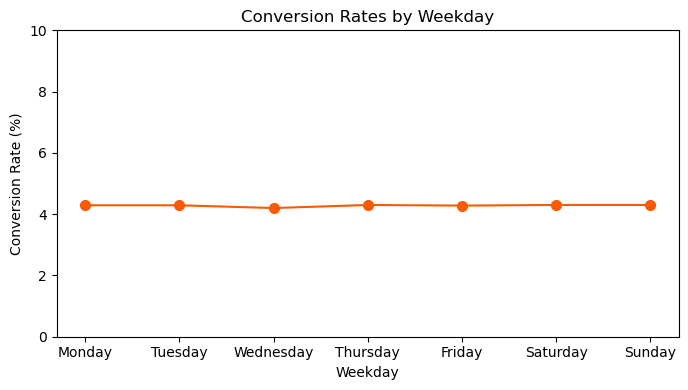

Conversion Rate by Weekday

weekday
Sunday       4.30
Saturday     4.30
Thursday     4.30
Monday       4.29
Tuesday      4.29
Friday       4.28
Wednesday    4.20
Name: event_id, dtype: float64


In [13]:
plot_cvr(df, group_by='weekday', title='Weekday')

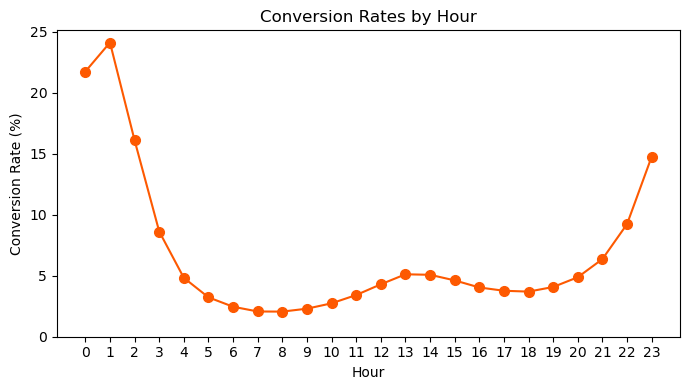

Conversion Rate by Hour

hour
1     24.13
0     21.75
2     16.11
23    14.77
22     9.24
3      8.63
21     6.37
13     5.12
14     5.08
20     4.88
4      4.83
15     4.62
12     4.30
19     4.08
16     4.04
17     3.77
18     3.70
11     3.42
5      3.23
10     2.74
6      2.46
9      2.30
7      2.07
8      2.06
Name: event_id, dtype: float64


In [14]:
plot_cvr(df, group_by='hour', title='Hour')

In [15]:
def plot_normalised_cvr(df, group_by, title):
    """
    Plots normalized conversion rates for a given grouping column.

    Parameters:
    - df: DataFrame
    - group_by: str (column name to group by, e.g., 'weekday' or 'hour')
    - title: str (title for the plot)
    """
    if group_by == 'weekday':
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        df[group_by] = pd.Categorical(df[group_by], categories=weekday_order, ordered=True)

    # Count total purchases and banner shows for the given group
    purchases = df[df['target'] == 1].groupby(group_by, observed=False)['event_id'].count().sort_index()
    views = df[df['event'] == 'banner_show'].groupby(group_by, observed=False)['event_id'].count().sort_index()

    # Calculate CVR per hour or weekday
    CVR_per_unit = (purchases / views * 100).round(2)
    
    # Plot CVR
    plt.figure(figsize=(7, 4))
    plt.plot(CVR_per_unit.index, CVR_per_unit.values, color='#fd5901', marker='o', 
             markersize=7, linestyle='-', label='Conversion Rate')
    plt.xlabel(group_by.capitalize())
    plt.ylabel('Conversion Rate (%)')
    plt.title(f'Normalized Conversion Rates by {title}')
    plt.ylim(0, max(CVR_per_unit.max() + 1, 10))
    if group_by == 'hour':
        plt.xticks(ticks=range(24))

    plt.tight_layout()
    plt.show()

    # Print conversion rates as a table
    print(f"Normalized Conversion Rate by {title}\n")
    print(CVR_per_unit.sort_values(ascending=False))

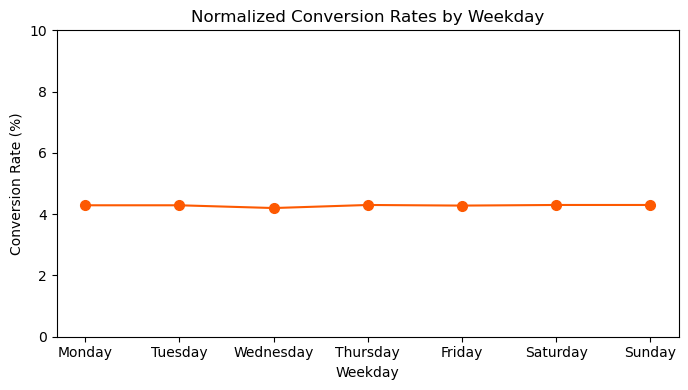

Normalized Conversion Rate by Weekday

weekday
Sunday       4.30
Saturday     4.30
Thursday     4.30
Monday       4.29
Tuesday      4.29
Friday       4.28
Wednesday    4.20
Name: event_id, dtype: float64


In [16]:
plot_normalised_cvr(df, group_by='weekday', title='Weekday')

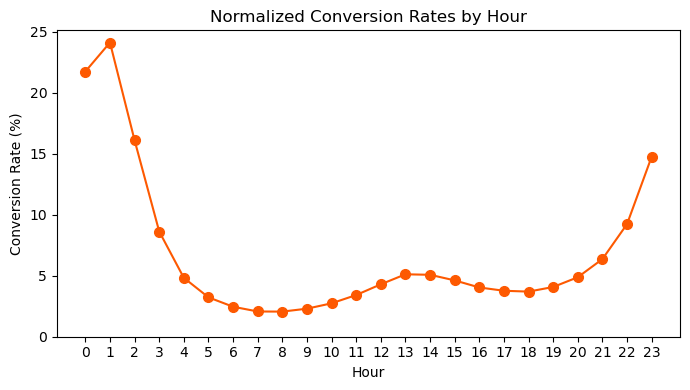

Normalized Conversion Rate by Hour

hour
1     24.13
0     21.75
2     16.11
23    14.77
22     9.24
3      8.63
21     6.37
13     5.12
14     5.08
20     4.88
4      4.83
15     4.62
12     4.30
19     4.08
16     4.04
17     3.77
18     3.70
11     3.42
5      3.23
10     2.74
6      2.46
9      2.30
7      2.07
8      2.06
Name: event_id, dtype: float64


In [17]:
plot_normalised_cvr(df, group_by='hour', title='Hour')

## Cohort Analysis

#### Weekly Cohorts

In [18]:
df['cohort_start'] = df.groupby('user_id')['time'].transform('min').dt.to_period('W').dt.start_time

# create a 'cohort_period' by calculating the number of weeks between the cohort start and each event
df['cohort_period'] = ((df['time'] - df['cohort_start']) / timedelta(weeks=1)).astype(int)

# count the number of active users in each cohort per week
cohorts = df.groupby(['cohort_start', 'cohort_period']).agg({'user_id': 'nunique'}).reset_index()

# pivot the table to have cohort_start as rows and cohort_period (weeks) as columns (absolute numbers)
cohort_pivot = cohorts.pivot_table(index='cohort_start', columns='cohort_period', values='user_id')

cohort_pivot.fillna(0, inplace=True)

cohort_pivot.head()

cohort_period,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
cohort_start,,,,,,,,,,,,,,,,,,,,,
2018-12-31,148308.0,38045.0,23164.0,10612.0,6925.0,4635.0,3850.0,3302.0,3057.0,2823.0,...,2466.0,2368.0,2187.0,2230.0,2112.0,2024.0,2003.0,1925.0,1684.0,847.0
2019-01-07,189465.0,31905.0,20877.0,10317.0,6995.0,4995.0,4207.0,3742.0,3630.0,3305.0,...,3103.0,2875.0,2825.0,2788.0,2627.0,2552.0,2566.0,2017.0,1099.0,0.0
2019-01-14,161304.0,25443.0,16433.0,7862.0,5530.0,3944.0,3399.0,3108.0,2881.0,2860.0,...,2396.0,2353.0,2272.0,2179.0,2147.0,2069.0,1765.0,940.0,0.0,0.0
2019-01-21,144036.0,21444.0,13896.0,6978.0,4783.0,3278.0,2938.0,2662.0,2576.0,2408.0,...,2140.0,2082.0,2008.0,1960.0,1752.0,1586.0,779.0,0.0,0.0,0.0
2019-01-28,135303.0,20326.0,13769.0,6487.0,4475.0,3147.0,2651.0,2530.0,2432.0,2250.0,...,1935.0,1835.0,1877.0,1809.0,1596.0,796.0,0.0,0.0,0.0,0.0


In [19]:
retention = (cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0) * 100).round(2)

retention.head()

cohort_period,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
cohort_start,,,,,,,,,,,,,,,,,,,,,
2018-12-31,100.0,25.65,15.62,7.16,4.67,3.13,2.60,2.23,2.06,1.90,...,1.66,1.60,1.47,1.50,1.42,1.36,1.35,1.30,1.14,0.57
2019-01-07,100.0,16.84,11.02,5.45,3.69,2.64,2.22,1.98,1.92,1.74,...,1.64,1.52,1.49,1.47,1.39,1.35,1.35,1.06,0.58,0.00
2019-01-14,100.0,15.77,10.19,4.87,3.43,2.45,2.11,1.93,1.79,1.77,...,1.49,1.46,1.41,1.35,1.33,1.28,1.09,0.58,0.00,0.00
2019-01-21,100.0,14.89,9.65,4.84,3.32,2.28,2.04,1.85,1.79,1.67,...,1.49,1.45,1.39,1.36,1.22,1.10,0.54,0.00,0.00,0.00
2019-01-28,100.0,15.02,10.18,4.79,3.31,2.33,1.96,1.87,1.80,1.66,...,1.43,1.36,1.39,1.34,1.18,0.59,0.00,0.00,0.00,0.00


In [20]:
cohort_pivot.to_csv('weekly_cohort_analysis.csv', index=True)
retention.to_csv('weekly_cohort_retention.csv', index=True)

#### Monthly Cohorts

In [21]:
df['cohort_start'] = df.groupby('user_id')['time'].transform('min').dt.to_period('M').dt.start_time

# calculate 'cohort_period' in months
df['cohort_period'] = (
    (df['month'].dt.year - df['cohort_start'].dt.year) * 12 +
    (df['month'].dt.month - df['cohort_start'].dt.month)
)

# count the number of active users in each cohort per month
cohorts = df.groupby(['cohort_start', 'cohort_period']).agg({'user_id': 'nunique'}).reset_index()

cohort_pivot = cohorts.pivot_table(index='cohort_start', columns='cohort_period', values='user_id')
cohort_pivot.fillna(0, inplace=True)

print(cohort_pivot)

cohort_period         0         1        2        3        4
cohort_start                                                
2019-01-01     721429.0  101786.0  44788.0  35091.0  28171.0
2019-02-01     532143.0   87993.0  28988.0  21902.0      0.0
2019-03-01     734050.0  126656.0  41760.0      0.0      0.0
2019-04-01     828082.0  140897.0      0.0      0.0      0.0
2019-05-01     810740.0       0.0      0.0      0.0      0.0


In [22]:
retention = (cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0) * 100).round(2)

print(retention)

cohort_period      0      1     2     3    4
cohort_start                                
2019-01-01     100.0  14.11  6.21  4.86  3.9
2019-02-01     100.0  16.54  5.45  4.12  0.0
2019-03-01     100.0  17.25  5.69  0.00  0.0
2019-04-01     100.0  17.01  0.00  0.00  0.0
2019-05-01     100.0   0.00  0.00  0.00  0.0


In [23]:
cohort_pivot.to_csv('monthly_cohort_analysis.csv', index=True)
retention.to_csv('monthly_cohort_retention.csv', index=True)

#### Repurchase Analysis

In [24]:
# count unique users in each cohort who made purchases
repurchase_cohorts = (
    df[df['event'] == 'order'] 
    .groupby(['cohort_start', 'cohort_period'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'users'})
    .reset_index()
)

# pivot the table to get cohort_start as rows and cohort_period as columns
repurchase_pivot = repurchase_cohorts.pivot(index='cohort_start', columns='cohort_period', values='users')

# add the initial cohort sizes (month 0)
initial_sizes = repurchase_pivot[0]
repurchase_rate = repurchase_pivot.div(initial_sizes, axis=0) * 100

repurchase_rate = repurchase_rate.fillna(0)

cohort_table = pd.concat([initial_sizes.rename('users'), repurchase_rate], axis=1)

cohort_table = cohort_table.fillna(0)

print("Repurchase Rate by Cohort\n")
print(cohort_table.round(2))

Repurchase Rate by Cohort

                users      0      1      2     3     4
cohort_start                                          
2019-01-01    34648.0  100.0  40.19  10.73  7.65  4.87
2019-02-01    29047.0  100.0  37.68   8.31  4.51  0.00
2019-03-01    38816.0  100.0  38.35   8.08  0.00  0.00
2019-04-01    42135.0  100.0  38.32   0.00  0.00  0.00
2019-05-01    29142.0  100.0   0.00   0.00  0.00  0.00


In [25]:
cohort_table.to_csv('monthly_repurchase_analysis.csv', index=True)

## Funnel Analysis

In [26]:
def funnel_analysis(df, group_by=None, title_prefix='Funnel Analysis'):
    """
    Perform a funnel analysis based on grouping criteria and display the results.

    Parameters:
    - df (DataFrame): Input dataset.
    - group_by (str or list): Columns to group by (e.g., 'month', 'platform', 'product').
    - title_prefix (str): Prefix for graph titles (e.g., "Funnel Analysis for").

    Returns:
    None
    """
    # keep only the first occurrence of each event per user and grouping
    group_columns = ['user_id', 'event']
    if group_by:
        if isinstance(group_by, str):
            group_by = [group_by]
        group_columns = ['user_id'] + group_by + ['event']

    first_events = (
        df.groupby(group_columns)
        .agg(first_time=('time', 'min'))
        .reset_index()
    )

    # count distinct users at each stage of the funnel for each group
    if group_by:
        funnel_counts = (
            first_events[first_events['event'].isin(['banner_show', 'banner_click', 'order'])]
            .groupby(group_by + ['event'])['user_id']
            .nunique()
            .unstack(fill_value=0)
            .reindex(columns=['banner_show', 'banner_click', 'order'], fill_value=0)
        )
    else:
        funnel_counts = (
            first_events[first_events['event'].isin(['banner_show', 'banner_click', 'order'])]
            .groupby('event')['user_id']
            .nunique()
            .reindex(['banner_show', 'banner_click', 'order'], fill_value=0)
        )

    # iterate through each group (or just once for the general funnel)
    if group_by:
        for group in funnel_counts.index:
            group_data = funnel_counts.loc[group]
            group_title = f"{title_prefix} for {group}"
            
            # create the table with stage, user counts, conversion rate, and drop-off rate
            funnel_data = pd.DataFrame({
                'Stage': ['Banner Show', 'Banner Click', 'Order'],
                'Users': group_data.values,
            })
            funnel_data['Conversion Rate (%)'] = (funnel_data['Users'] / funnel_data['Users'].iloc[0] * 100).round(1)
            funnel_data['Drop-Off (%)'] = (100-(funnel_data['Users'] / funnel_data['Users'].shift(1) * 100)).round(1)
            funnel_data['Drop-Off (%)'] = funnel_data['Drop-Off (%)'].fillna(0)

            print(group_title)
            print(funnel_data)

            plt.figure(figsize=(6, 4))
            plt.barh(funnel_data['Stage'], funnel_data['Users'], color=['#faab36', '#f78104', '#fd5901'], edgecolor='k')
            plt.xlabel('Number of Users')
            plt.ylabel('Funnel Stage')
            plt.title(group_title)
            plt.gca().invert_yaxis()
            apply_global_number_format()
            plt.tight_layout()
            plt.show()
    else:
        group_data = funnel_counts
        group_title = title_prefix
        
        funnel_data = pd.DataFrame({
            'Stage': ['Banner Show', 'Banner Click', 'Order'],
            'Users': group_data.values,
        })
        funnel_data['Conversion Rate (%)'] = (funnel_data['Users'] / funnel_data['Users'].iloc[0] * 100).round(1)
        funnel_data['Drop-Off (%)'] = (100-(funnel_data['Users'] / funnel_data['Users'].shift(1) * 100)).round(1)
        funnel_data['Drop-Off (%)'] = funnel_data['Drop-Off (%)'].fillna(0)
        
        print(group_title)
        print(funnel_data)

        plt.figure(figsize=(6, 4))
        plt.barh(funnel_data['Stage'], funnel_data['Users'], color=['#faab36', '#f78104', '#fd5901'], edgecolor='k')
        plt.xlabel('Number of Users')
        plt.ylabel('Funnel Stage')
        plt.title(group_title)
        plt.gca().invert_yaxis()
        apply_global_number_format()
        plt.tight_layout()
        plt.show()

Funnel Analysis
          Stage    Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  3592738                100.0           0.0
1  Banner Click   620508                 17.3          82.7
2         Order   237866                  6.6          61.7


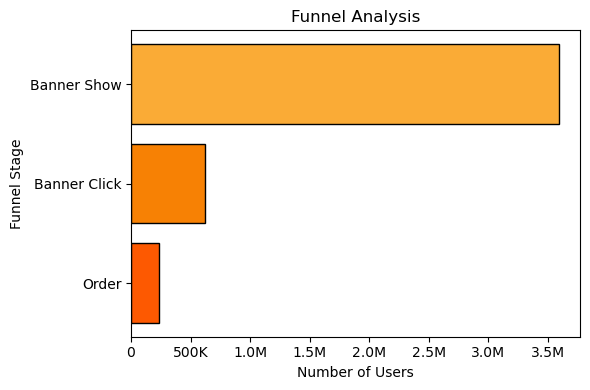

In [27]:
funnel_analysis(df, title_prefix='Funnel Analysis')

#### Monthly Funnels

Funnel Analysis by Month for 2019-01
          Stage   Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  708606                100.0           0.0
1  Banner Click  111604                 15.7          84.3
2         Order   34648                  4.9          69.0


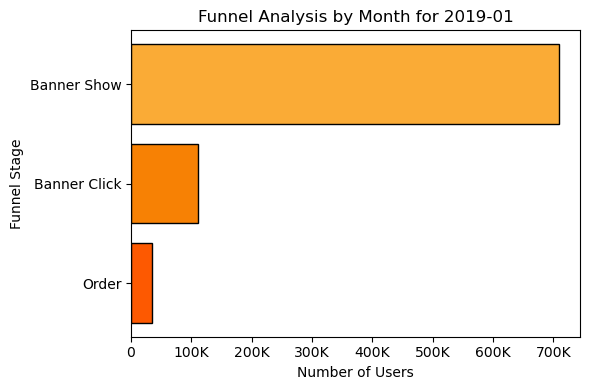

Funnel Analysis by Month for 2019-02
          Stage   Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  609434                100.0           0.0
1  Banner Click   90592                 14.9          85.1
2         Order   42971                  7.1          52.6


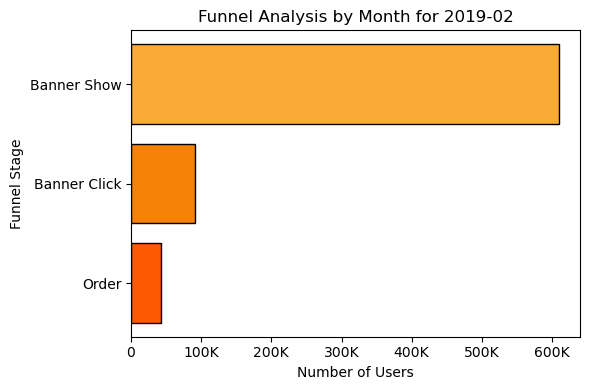

Funnel Analysis by Month for 2019-03
          Stage   Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  840886                100.0           0.0
1  Banner Click  126248                 15.0          85.0
2         Order   53477                  6.4          57.6


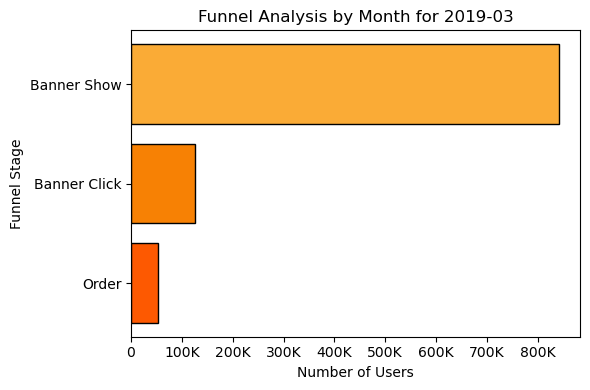

Funnel Analysis by Month for 2019-04
          Stage   Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  989185                100.0           0.0
1  Banner Click  149898                 15.2          84.8
2         Order   62086                  6.3          58.6


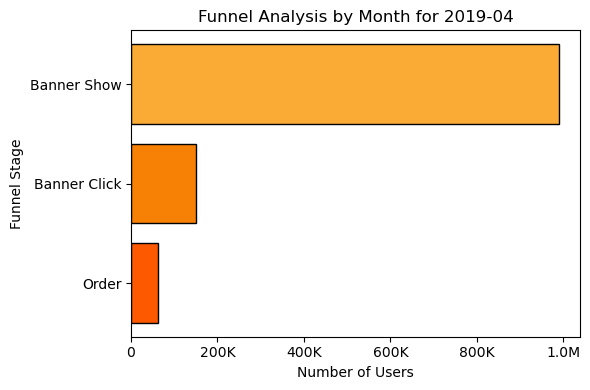

Funnel Analysis by Month for 2019-05
          Stage    Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  1024781                100.0           0.0
1  Banner Click   164224                 16.0          84.0
2         Order    51424                  5.0          68.7


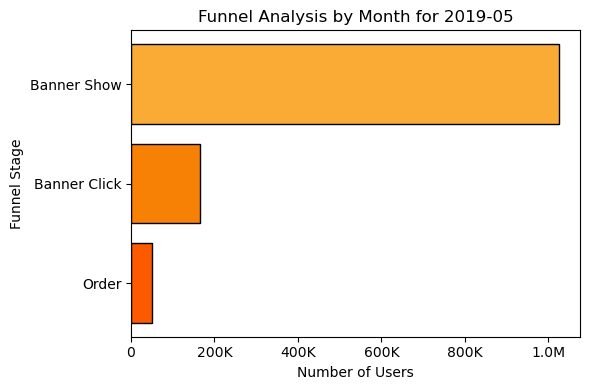

In [28]:
funnel_analysis(df, group_by='month', title_prefix='Funnel Analysis by Month')

#### Platform Funnels

Funnel Analysis by Platform for desktop
          Stage    Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  1182984                100.0           0.0
1  Banner Click    84436                  7.1          92.9
2         Order   125404                 10.6         -48.5


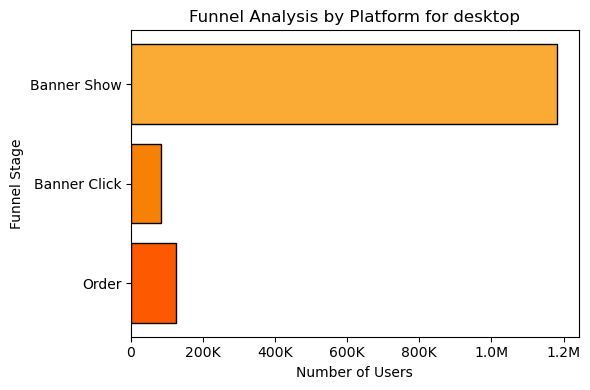

Funnel Analysis by Platform for mobile
          Stage    Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  2429294                100.0           0.0
1  Banner Click   536395                 22.1          77.9
2         Order   112574                  4.6          79.0


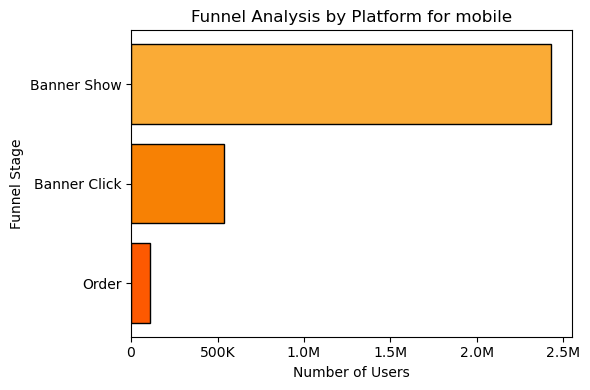

In [29]:
funnel_analysis(df, group_by='platform', title_prefix='Funnel Analysis by Platform')

#### Product Funnels

Funnel Analysis by Product for accessories
          Stage    Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  1155775                100.0           0.0
1  Banner Click   131998                 11.4          88.6
2         Order    44160                  3.8          66.5


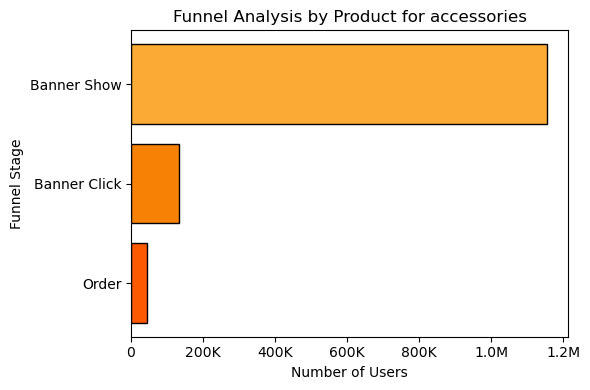

Funnel Analysis by Product for clothes
          Stage    Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  1164914                100.0           0.0
1  Banner Click   210109                 18.0          82.0
2         Order   110347                  9.5          47.5


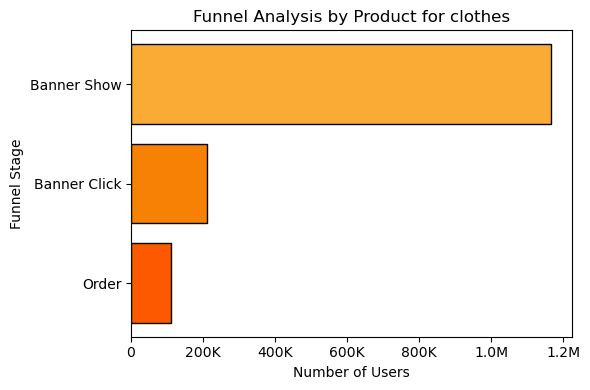

Funnel Analysis by Product for nutrition
          Stage    Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  1173163                100.0           0.0
1  Banner Click   139854                 11.9          88.1
2         Order    23609                  2.0          83.1


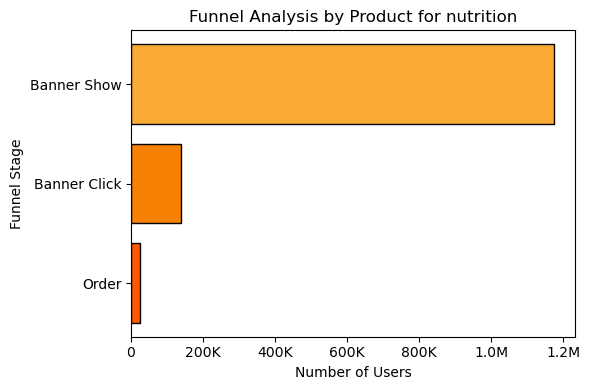

Funnel Analysis by Product for sneakers
          Stage    Users  Conversion Rate (%)  Drop-Off (%)
0   Banner Show  1163806                100.0           0.0
1  Banner Click   174801                 15.0          85.0
2         Order    66917                  5.7          61.7


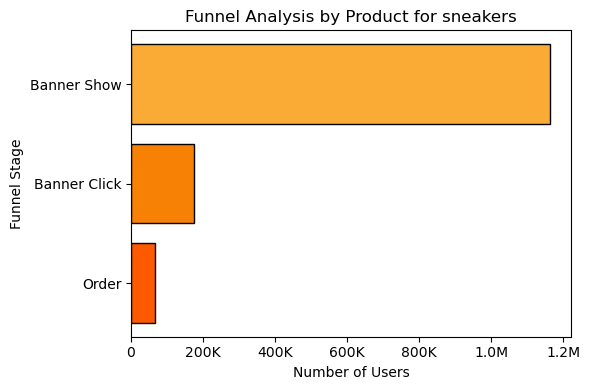

In [30]:
funnel_analysis(df, group_by='product', title_prefix='Funnel Analysis by Product')

## A/B Testing

In [31]:
# group by platform to calculate the total number of banner shows and purchases for each platform
platform_summary_CVR = df.groupby('platform').agg({
    'event': lambda x: (x == 'banner_show').sum(),  # total banner shows
    'target': 'sum'  # total purchases
}).rename(columns={'event': 'total_banner_shows', 'target': 'total_purchases'})

# calculate conversion rate
platform_summary_CVR['conversion_rate'] = (platform_summary_CVR['total_purchases'] / platform_summary_CVR['total_banner_shows'] * 100).round(1)

print(platform_summary_CVR)

          total_banner_shows  total_purchases  conversion_rate
platform                                                      
desktop              1657265           133181              8.0
mobile               4155814           115541              2.8


Here we see the sample sizes for desktop (1,657,265 banner shows) and mobile (4,155,814 banner shows). In this case, the mobile group’s sample size is more than twice that of the desktop group. 

However, both groups have sufficiently large sample sizes to produce reliable statistical results despite this difference.

In [32]:
conversions = platform_summary_CVR['total_purchases'].values
banner_shows = platform_summary_CVR['total_banner_shows'].values 

# perform Z-test for two proportions
z_stat, p_value = proportions_ztest(conversions, banner_shows)

print("A/B Test between Desktop's and Mobile's CVR\n")
print(f"Z-statistic: {z_stat.round(2)}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("We reject the null hypothesis. There is a significant difference in conversion rates.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in conversion rates.")

A/B Test between Desktop's and Mobile's CVR

Z-statistic: 282.69
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.


In [33]:
# group by platform to calculate the total number of banner shows and banner clicks for each platform
platform_summary_CTR = df.groupby(['platform', 'event']).size().unstack(fill_value=0).reset_index()

platform_summary_CTR = platform_summary_CTR.rename(columns={
    'banner_show': 'total_banner_shows',
    'banner_click': 'total_banner_clicks'
})

platform_summary_CTR['click_through_rate'] = platform_summary_CTR['total_banner_clicks'] / platform_summary_CTR['total_banner_shows'] * 100

# extract the clicks and banner shows for Z-test
clicks = platform_summary_CTR['total_banner_clicks'].values
banner_shows = platform_summary_CTR['total_banner_shows'].values

z_stat, p_value = proportions_ztest(clicks, banner_shows)

print("A/B Test between Desktop's and Mobile's CTR\n")
print(f"Z-statistic: {z_stat.round(2)}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("We reject the null hypothesis. There is a significant difference in CTR between desktop and mobile.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in CTR between desktop and mobile.")

A/B Test between Desktop's and Mobile's CTR

Z-statistic: -309.31
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR between desktop and mobile.


In [34]:
# group by product and platform to calculate the total number of banner shows and purchases for each product/platform
platform_summary_by_product_CVR = df.groupby(['product', 'platform']).agg({
    'event': lambda x: (x == 'banner_show').sum(),  # total banner shows
    'target': 'sum'  # total purchases
}).rename(columns={'event': 'total_banner_shows', 'target': 'total_purchases'}).reset_index()

# loop through each product type and run the Z-test
alpha = 0.05
bonferroni_alpha = alpha / 4  # bonferroni correction for 4 product types

print("A/B Test between Desktop's and Mobile's CVR for Each Product\n")
for product in ['sneakers', 'nutrition', 'accessories', 'clothes']:
    product_data = platform_summary_by_product_CVR[platform_summary_by_product_CVR['product'] == product]
    
    desktop_data = product_data[product_data['platform'] == 'desktop']
    mobile_data = product_data[product_data['platform'] == 'mobile']
    
    conversions = [desktop_data['total_purchases'].values[0], mobile_data['total_purchases'].values[0]]
    banner_shows = [desktop_data['total_banner_shows'].values[0], mobile_data['total_banner_shows'].values[0]]
    
    z_stat, p_value = proportions_ztest(conversions, banner_shows)
    
    print(f"Product: {product}")
    print(f"Z-statistic: {z_stat.round(2)}")
    print(f"P-value: {p_value}")
    
    if p_value < bonferroni_alpha:
        print("We reject the null hypothesis. There is a significant difference in conversion rates.\n")
    else:
        print("We fail to reject the null hypothesis. There is no significant difference in conversion rates.\n")

A/B Test between Desktop's and Mobile's CVR for Each Product

Product: sneakers
Z-statistic: 116.89
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.

Product: nutrition
Z-statistic: 68.96
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.

Product: accessories
Z-statistic: 100.74
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.

Product: clothes
Z-statistic: 236.68
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.



In [35]:
# group by product and platform to calculate the total number of banner shows and banner clicks for each product/platform
platform_summary_by_product_CTR = df.groupby(['product', 'platform', 'event']).size().unstack(fill_value=0).reset_index()

platform_summary_by_product_CTR = platform_summary_by_product_CTR.rename(columns={
    'banner_show': 'total_banner_shows',
    'banner_click': 'total_banner_clicks'
})

# loop through each product type and run the Z-test for CTR
alpha = 0.05
bonferroni_alpha = alpha / 4  # bonferroni correction for 4 product types

print("A/B Test between Desktop's and Mobile's CTR for Each Product\n")
for product in ['sneakers', 'nutrition', 'accessories', 'clothes']:
    product_data = platform_summary_by_product_CTR[platform_summary_by_product_CTR['product'] == product]
    
    desktop_data = product_data[product_data['platform'] == 'desktop']
    mobile_data = product_data[product_data['platform'] == 'mobile']
    
    clicks = [desktop_data['total_banner_clicks'].values[0], mobile_data['total_banner_clicks'].values[0]]
    banner_shows = [desktop_data['total_banner_shows'].values[0], mobile_data['total_banner_shows'].values[0]]
    
    z_stat, p_value = proportions_ztest(clicks, banner_shows)

    print(f"Product: {product}")
    print(f"Z-statistic: {z_stat.round(2)}")
    print(f"P-value: {p_value}")

    if p_value < bonferroni_alpha:
        print("We reject the null hypothesis. There is a significant difference in CTR between desktop and mobile.\n")
    else:
        print("We fail to reject the null hypothesis. There is no significant difference in CTR between desktop and mobile.\n")

A/B Test between Desktop's and Mobile's CTR for Each Product

Product: sneakers
Z-statistic: -168.32
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR between desktop and mobile.

Product: nutrition
Z-statistic: -168.06
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR between desktop and mobile.

Product: accessories
Z-statistic: -127.7
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR between desktop and mobile.

Product: clothes
Z-statistic: -156.7
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR between desktop and mobile.



In [36]:
# group by product to calculate the total number of banner shows and purchases for each product
product_summary_CVR = df.groupby('product').agg({
    'event': lambda x: (x == 'banner_show').sum(),  # total banner shows
    'target': 'sum'  # total purchases
}).rename(columns={'event': 'total_banner_shows', 'target': 'total_purchases'}).reset_index()

# get the conversion rates (total purchases / total banner shows) for each product
product_summary_CVR['conversion_rate'] = product_summary_CVR['total_purchases'] / product_summary_CVR['total_banner_shows'] * 100

conversions = product_summary_CVR['total_purchases'].values
banner_shows = product_summary_CVR['total_banner_shows'].values

alpha = 0.05
bonferroni_alpha = alpha / 6  # bonferroni correction for 6 comparisons among 4 products

print("A/B Test of CVR between Product Categories\n")
for i in range(len(conversions)):
    for j in range(i + 1, len(conversions)):
        z_stat, p_value = proportions_ztest([conversions[i], conversions[j]], [banner_shows[i], banner_shows[j]])
        print(f"Comparing {product_summary_CVR['product'].iloc[i]} vs. {product_summary_CVR['product'].iloc[j]}")
        print(f"Z-statistic: {z_stat.round(2)}")
        print(f"P-value: {p_value}")

        if p_value < bonferroni_alpha:
            print("We reject the null hypothesis. There is a significant difference in conversion rates.\n")
        else:
            print("We fail to reject the null hypothesis. There is no significant difference in conversion rates.\n")

A/B Test of CVR between Product Categories

Comparing accessories vs. clothes
Z-statistic: -175.04
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.

Comparing accessories vs. nutrition
Z-statistic: 82.88
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.

Comparing accessories vs. sneakers
Z-statistic: -69.1
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.

Comparing clothes vs. nutrition
Z-statistic: 248.38
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.

Comparing clothes vs. sneakers
Z-statistic: 109.36
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.

Comparing nutrition vs. sneakers
Z-statistic: -149.13
P-value: 0.0
We reject the null hypothesis. There is a significant difference in conversion rates.



In [37]:
# group by product to calculate the total number of banner shows and banner clicks for each product
product_summary_CTR = df.groupby(['product', 'event']).size().unstack(fill_value=0).reset_index()

product_summary_CTR = product_summary_CTR.rename(columns={
    'banner_show': 'total_banner_shows',
    'banner_click': 'total_banner_clicks'
})

# calculate CTR for each product
product_summary_CTR['click_through_rate'] = product_summary_CTR['total_banner_clicks'] / product_summary_CTR['total_banner_shows'] * 100

clicks = product_summary_CTR['total_banner_clicks'].values
banner_shows = product_summary_CTR['total_banner_shows'].values

alpha = 0.05
bonferroni_alpha = alpha / 6  # bonferroni correction for 6 comparisons among 4 products

print("A/B Test of CTR between Product Categories\n")
for i in range(len(clicks)):
    for j in range(i + 1, len(clicks)):
        z_stat, p_value = proportions_ztest([clicks[i], clicks[j]], [banner_shows[i], banner_shows[j]])
        print(f"Comparing {product_summary_CTR['product'].iloc[i]} vs. {product_summary_CTR['product'].iloc[j]}")
        print(f"Z-statistic: {z_stat.round(2)}")
        p_value_threshold = 1e-16
        if p_value < p_value_threshold:
            p_value = 0.0
        print(f"P-value: {p_value}")

        if p_value < bonferroni_alpha:
            print("We reject the null hypothesis. There is a significant difference in CTR.\n")
        else:
            print("We fail to reject the null hypothesis. There is no significant difference in CTR.\n")

A/B Test of CTR between Product Categories

Comparing accessories vs. clothes
Z-statistic: -148.11
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR.

Comparing accessories vs. nutrition
Z-statistic: -12.39
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR.

Comparing accessories vs. sneakers
Z-statistic: -84.51
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR.

Comparing clothes vs. nutrition
Z-statistic: 136.68
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR.

Comparing clothes vs. sneakers
Z-statistic: 64.46
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR.

Comparing nutrition vs. sneakers
Z-statistic: -72.57
P-value: 0.0
We reject the null hypothesis. There is a significant difference in CTR.



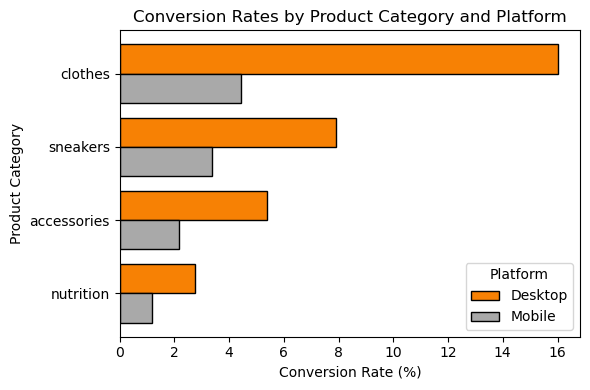

In [38]:
platform_summary_by_product_CVR['conversion_rate'] = (
    platform_summary_by_product_CVR['total_purchases'] / platform_summary_by_product_CVR['total_banner_shows'] * 100
)

pivot_df = platform_summary_by_product_CVR.pivot(index='product', columns='platform', values='conversion_rate')

pivot_df['total_conversion_rate'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='total_conversion_rate', ascending=False)
pivot_df = pivot_df.drop(columns='total_conversion_rate')

fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.4

product_indices = range(len(pivot_df.index))

ax.barh([x - bar_width / 2 for x in product_indices], pivot_df['desktop'], 
        height=bar_width, color='#f78104', edgecolor='black', label='Desktop')

ax.barh([x + bar_width / 2 for x in product_indices], pivot_df['mobile'], 
        height=bar_width, color='darkgrey', edgecolor='black', label='Mobile')

plt.gca().invert_yaxis()
ax.set_yticks(product_indices)
ax.set_yticklabels(pivot_df.index)
ax.set_xlabel('Conversion Rate (%)')
ax.set_ylabel('Product Category')
ax.set_title('Conversion Rates by Product Category and Platform')
ax.legend(title='Platform')

plt.tight_layout()
plt.show()

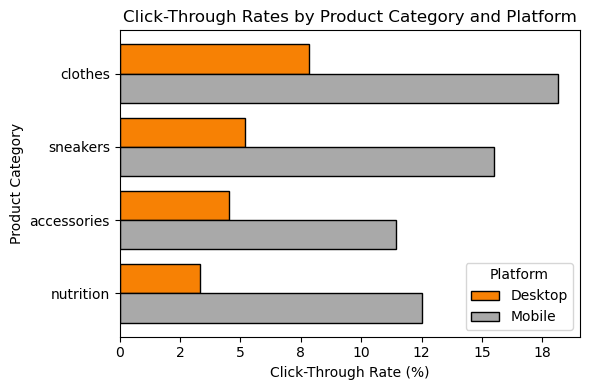

In [39]:
platform_summary_by_product_CTR['click_through_rate'] = (
    platform_summary_by_product_CTR['total_banner_clicks'] / platform_summary_by_product_CTR['total_banner_shows'] * 100
)

pivot_df = platform_summary_by_product_CTR.pivot(index='product', columns='platform', values='click_through_rate')

pivot_df['total_click_through_rate'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='total_click_through_rate', ascending=False)
pivot_df = pivot_df.drop(columns='total_click_through_rate')

fig, ax = plt.subplots(figsize=(6, 4))

bar_width = 0.4

product_indices = range(len(pivot_df.index))

ax.barh([x - bar_width / 2 for x in product_indices], pivot_df['desktop'], 
        height=bar_width, color='#f78104', edgecolor='k', label='Desktop')

ax.barh([x + bar_width / 2 for x in product_indices], pivot_df['mobile'], 
        height=bar_width, color='darkgrey', edgecolor='k', label='Mobile')

plt.gca().invert_yaxis()
ax.set_yticks(product_indices)
ax.set_yticklabels(pivot_df.index)
ax.set_xlabel('Click-Through Rate (%)')
ax.set_ylabel('Product Category')
ax.set_title('Click-Through Rates by Product Category and Platform')
ax.legend(title='Platform')

apply_global_number_format()

plt.tight_layout()
plt.show()